<a href="https://colab.research.google.com/github/agorastats/mitosisDEEP/blob/master/colabs/retrain_icpr12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# todo
# train with autoencoders: https://www.youtube.com/watch?v=hTpq9lzAb8M&t=710s

In [2]:
# import packages
import os
import tensorflow as tf
import numpy as np 
import random
import cv2
from tensorflow import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [151]:
# utils

MAX_SIZE = 255.

def image_normalize(img):
    img = np.asarray(img, dtype=np.float64)
    if img.max() > 1.0:
        img /= MAX_SIZE
    return img

def read_and_normalize_image(filename, convert=None):
    assert os.path.exists(filename), 'Problems reading filename %s' % filename
    image = cv2.imread(filename)
    if convert is not None:
        image = cv2.cvtColor(image, convert)
    image = image_normalize(image)
    # return img2np(image)
    return image

def read_and_normalize_patches_of_folder(folder_path, convert=None):
    all_patches_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    print('total patches: ', len(all_patches_files))
    all_patches_list = []
    for i, patch in enumerate(all_patches_files):
        if i%500==0:
          print('processed number of patches: %i' % i)
        all_patches_list.append(read_and_normalize_image(os.path.join(folder_path, patch), convert=convert))
    return all_patches_list



In [ ]:
dir_path = 'drive/MyDrive/mitosis_data'

# images_path = os.path.join(dir_path, 'images_aug')
# masks_path = os.path.join(dir_path, 'masks_aug')
!unzip '/content/drive/MyDrive/mitosis_data/images_aug.zip' -d "/content/images_aug"
!unzip '/content/drive/MyDrive/mitosis_data/masks_aug.zip' -d "/content/masks_aug"

In [33]:
images_list = read_and_normalize_patches_of_folder('/content/images_aug/images_aug', convert=None)
masks_list = read_and_normalize_patches_of_folder('/content/masks_aug/masks_aug', convert=cv2.COLOR_BGR2GRAY)

images = np.array(images_list)
masks = np.array(masks_list)
masks = np.expand_dims(masks, -1)
print('total images patches: ', np.array(images).shape)
print('total masks patches: ', np.array(masks).shape)

total patches:  2712
processed number of patches: 0
processed number of patches: 500
processed number of patches: 1000
processed number of patches: 1500
processed number of patches: 2000
processed number of patches: 2500
total patches:  2712
processed number of patches: 0
processed number of patches: 500
processed number of patches: 1000
processed number of patches: 1500
processed number of patches: 2000
processed number of patches: 2500
total images patches:  (2712, 256, 256, 3)
total masks patches:  (2712, 256, 256, 1)


In [34]:
# utils keras
from keras import backend as K

# ref: https://github.com/nauyan/Segmentation/blob/master/Code/utils/lossfunctions.py
# ref: https://github.com/nauyan/Segmentation/blob/master/Code/utils/metricfunctions.py

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
  return 1 - numerator / denominator

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [35]:
# load trained model
from keras.models import load_model
model = load_model("drive/MyDrive/mitosis_data/UNET-Best.h5", compile=False)
model.save_weights("drive/MyDrive/mitosis_data/pretrained_weights.h5")
# build model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])
# model.summary()
model.load_weights("drive/MyDrive/mitosis_data/pretrained_weights.h5")

In [39]:
seed_val=24
from keras.preprocessing.image import ImageDataGenerator

# img_data_gen_args = dict(rescale=1. / 255,
#                      rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      fill_mode='reflect')

# mask_data_gen_args = dict(rescale=1. / 255,
#                      rotation_range=90,
#                      width_shift_range=0.3,
#                      height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      fill_mode='reflect',
#                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.33)

image_data_generator = ImageDataGenerator()
# image_data_generator.fit(X_train, augment=True, seed=seed_val)
image_data_generator.fit(X_train)
# image_generator = image_data_generator.flow(X_train, seed=seed_val)
image_generator = image_data_generator.flow(X_train, seed=seed_val)
valid_img_generator = image_data_generator.flow(X_test, seed=seed_val)

# mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator = ImageDataGenerator()
# mask_data_generator.fit(y_train, augment=True, seed=seed_val)
mask_data_generator.fit(y_train)
mask_generator = mask_data_generator.flow(y_train, seed=seed_val)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed_val)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [43]:
# train model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
steps_per_epoch = 20
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=10, callbacks=[callback])

Epoch 1/10
20/20 [==============================] - 24s 1s/step - loss: -128.8238 - dice_coef: 1.8855 - accuracy: 0.9547 - val_loss: 7.3634 - val_dice_coef: 0.2909 - val_accuracy: 0.9783
Epoch 2/10
20/20 [==============================] - 19s 978ms/step - loss: -134.9072 - dice_coef: 1.8603 - accuracy: 0.9488 - val_loss: 1.0276 - val_dice_coef: 0.4663 - val_accuracy: 0.9786
Epoch 3/10
20/20 [==============================] - 19s 981ms/step - loss: -148.0566 - dice_coef: 1.8685 - accuracy: 0.9448 - val_loss: -16.5572 - val_dice_coef: 0.8807 - val_accuracy: 0.9784
Epoch 4/10
20/20 [==============================] - 19s 974ms/step - loss: -156.1822 - dice_coef: 1.8832 - accuracy: 0.9412 - val_loss: -33.7982 - val_dice_coef: 1.0632 - val_accuracy: 0.9781
Epoch 5/10
20/20 [==============================] - 19s 981ms/step - loss: -161.5583 - dice_coef: 1.8641 - accuracy: 0.9310 - val_loss: -45.3175 - val_dice_coef: 1.4408 - val_accuracy: 0.9753
Epoch 6/10
20/20 [=============================

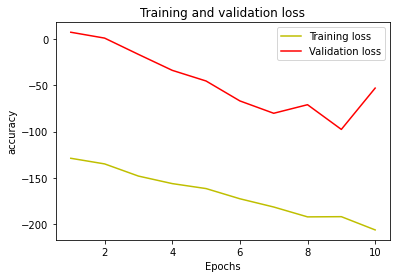

In [185]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

test image size:  (1173, 2560, 3)
test image resized size:  (1024, 2560, 3)


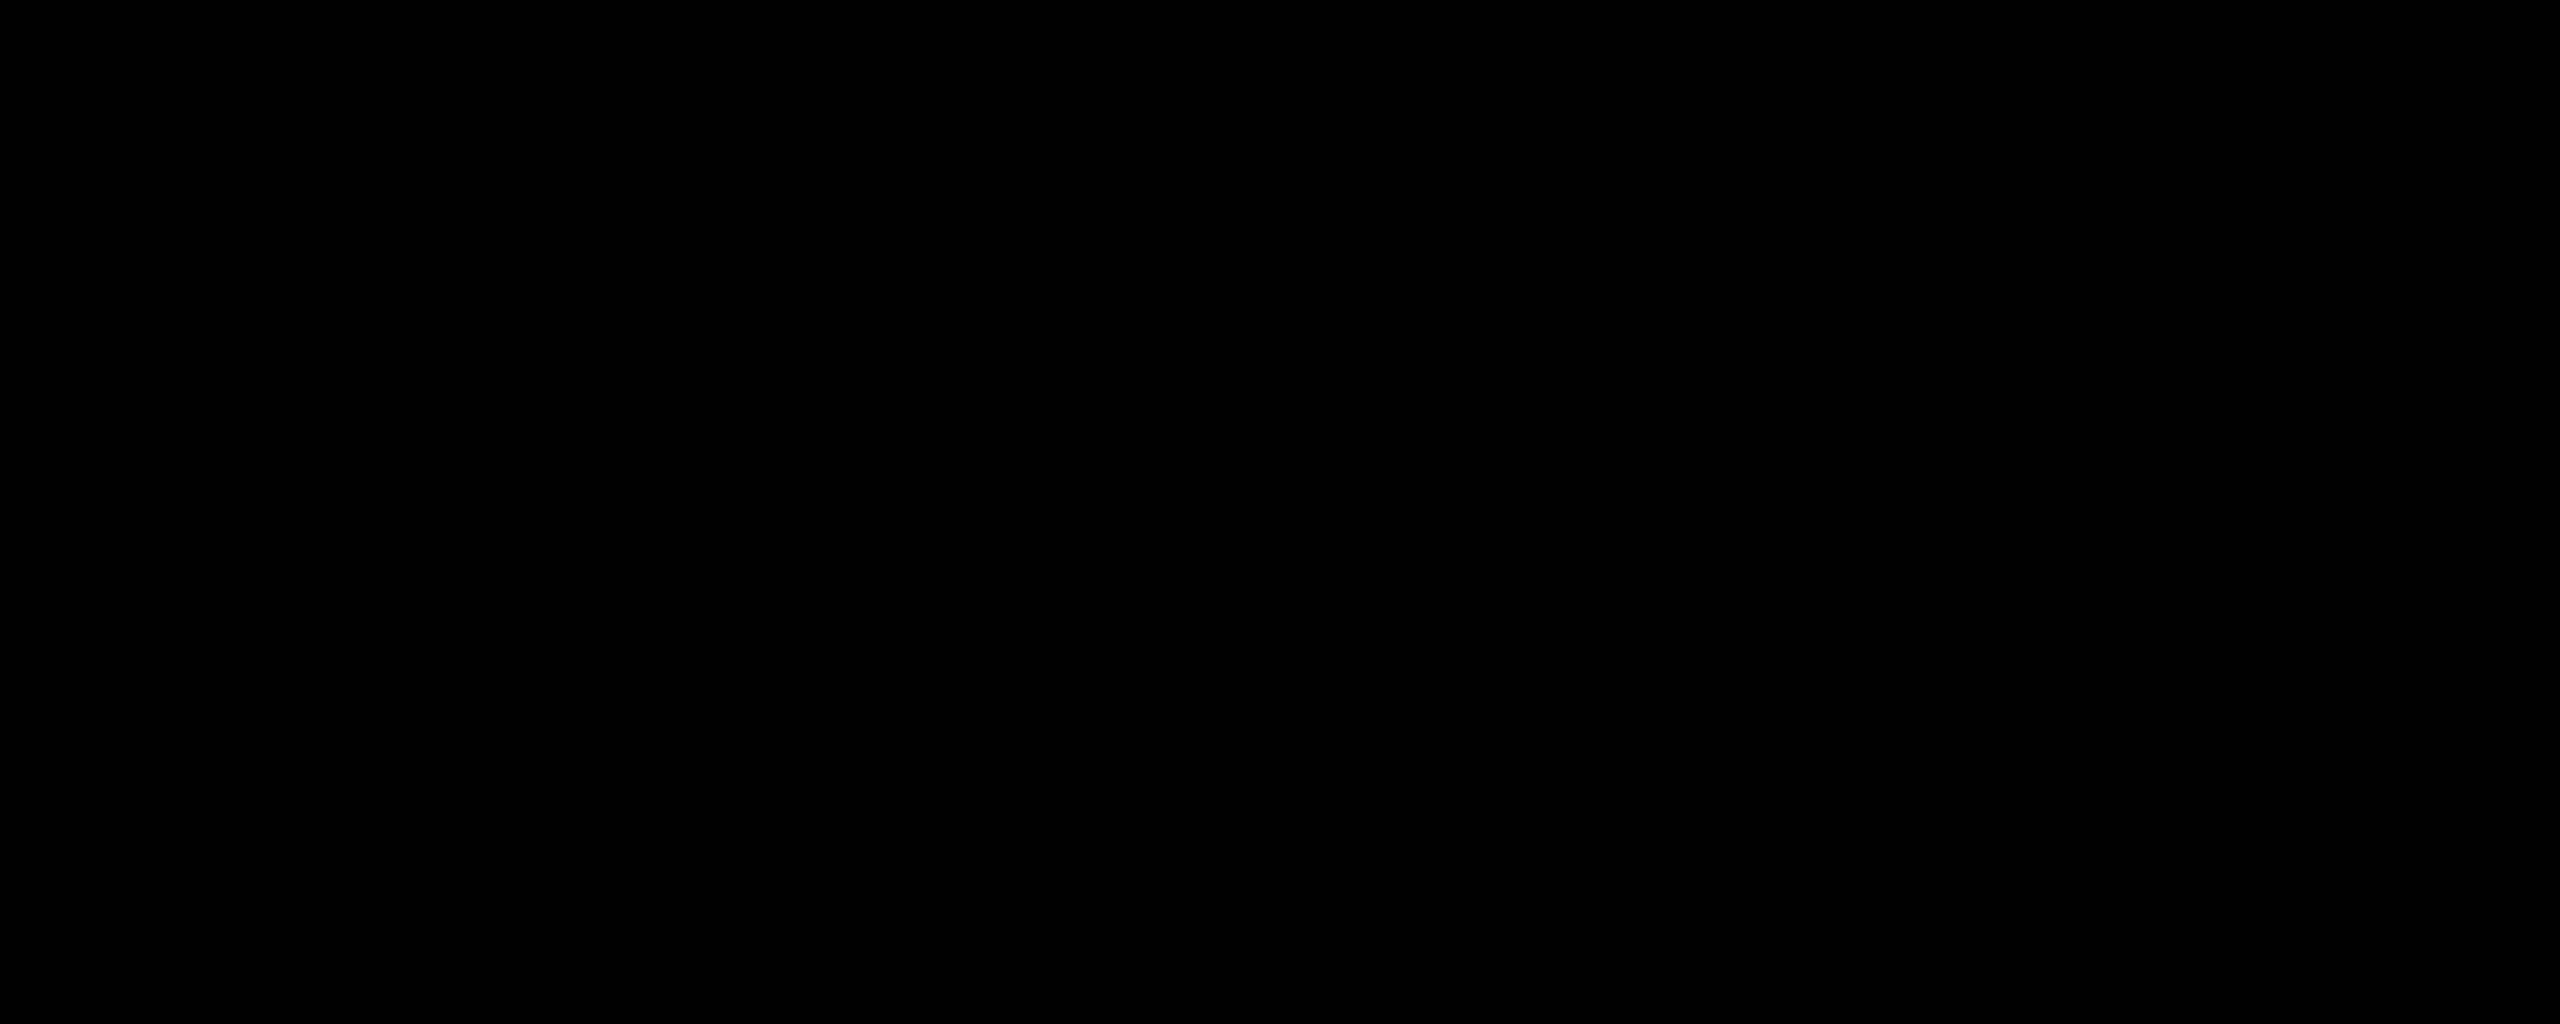

In [244]:
# ref: https://www.youtube.com/watch?v=HrGn4uFrMOM
# predict on some images
from google.colab.patches import cv2_imshow
# !pip install patchify
from patchify import patchify, unpatchify
PATCH_SIZE  = 256
test_path = 'drive/MyDrive/mitosis_data/23.jpg'
test_image = read_and_normalize_image(test_path)

size_x = (test_image.shape[1]//PATCH_SIZE)*patch_size   # nearest size divisible by our patch size
size_y = (test_image.shape[0]//PATCH_SIZE)*patch_size   # nearest size divisible by our patch size
print('test image size: ', test_image.shape)
test_image = cv2.resize(test_image, (size_x, size_y))
print('test image resized size: ', test_image.shape)

# test_image = cv2.imread(test_path)
patches = patchify(test_image, (256, 256, 3), step=256)
patches = patches[:, :, 0, :, :, :]
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i,j,:,:, :]
        single_patch = np.expand_dims(single_patch, axis=0) # (256,256,3) to (1,256,256,3)
        # Predict and threshold for values above 0.5 probability
        single_patch_prediction = (model.predict(single_patch) > 0.5).astype(np.uint8)
        predicted_patches.append(single_patch_prediction[0, :, :])


predicted_patches_reshaped = np.reshape(predicted_patches, [patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]]) 
reconstructed_image = unpatchify(predicted_patches_reshaped, (test_image.shape[0], test_image.shape[1]))
cv2_imshow(reconstructed_image)
